In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv


# Topic Modelling in Python
**Preface** : This article aims to provide consolidated information on the underlying topic and is not to be considered as the original work. The information and the code are repurposed through several online articles, research papers, books, and open source code.


## What is Aspect ?
Before we get into the several strategies for aspect-level sentiment analysis, we must first define an aspect. Aspects are a set of semantically rich, concept-centric terms that signify specific features or characteristics of the review or comment. For example, If we consider Example shown below Location, and food are all aspects to consider.

![](https://cdn-images-1.medium.com/v2/resize:fit:800/1*WVtjRoKbG8VHhjvPWxwO_w.png)


Aspect-based sentiment analysis (ABSA) is a text analysis technique that categorizes data by aspect and identifies the sentiment attributed to each one. It is also known as fine-grained opinion mining, is the task of determining the sentiment of a text with respect to a specific aspect. Aspect-based sentiment analysis is a relatively new field of research that has emerged in response to the limitations of traditional sentiment analysis methods.
Traditional sentiment analysis methods treat a text as a whole and assign it a single sentiment label (e.g., positive, negative, or neutral). This is adequate for many tasks, but there are also many situations where it would be useful to know the sentiment of a text with respect to a specific aspect. For example, consider a restaurant review. The reviewer might give the restaurant a positive overall rating but mention poor service. In this case, it would be useful to know that the sentiment towards the aspect of "service" is negative, even though the overall sentiment is positive. In some cases, customers may be satisfied with the service but there might be one thing they do not like about it, and we can extract that aspect using ASBA, which will help us improve the customer's overall experience.
Aspect Based Sentiment Analysis can be categorized into two types:-
Supervised ABSA :- In Supervised approach we provide the seed words which than help supervised model to extract aspects of the sentence. If it identifies the particular aspects for that seed, then it tags those sentences with those aspects.
Unsupervised ABSA :- As it is obvious providing the seed for each sentence is a difficult task plus let say if our dataset is large (20–100k) than that will become a nightmare. Topic Modeling is the technique which helps extract latent topics from a document, in our case we will extract aspect from a sentence using topic modeling techniques such as latent Dirichlet algorithm (LDA).

Aspect Based Sentiment Analysis is a Natural Language Processing (NLP) Based Approach so we will deal it like that and follow the below mentioned pipeline for an NLP task.

In [3]:
# For genism library (Use to visualize Topics)
!pip install pandas==1.5.3

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# import visulizatoin using Plotly library
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.subplots import make_subplots

# For data visualization
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
%matplotlib inline

# To view the most frequent words
from wordcloud import WordCloud

# Timer to track the run time or completeion of execution
from tqdm import tqdm

# Data Manipulation
import pandas as pd
import numpy as np

# To use regular expression
import re

# To find frequency of a token occuring in corpus
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Used different type of containers to store collection
from collections import Counter, defaultdict
import itertools
import collections

# use algo related to NLP
import nltk
from nltk import bigrams
from nltk import ngrams
from nltk.corpus import stopwords

# Lematization
import spacy

# To visualize data in graph format
import networkx as nx

# Decode emoji's into text
!pip install demoji
import demoji

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

/opt/conda/lib/python3.10/site-packages/nltk/decorators.py:69: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.6 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



In [6]:
df = pd.read_csv("/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv")
df.head() 

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


The table consist of **20491** rows and only two columns which are Review given by a customer and its rating

In [7]:
df.shape

(20491, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [9]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

No Missing values in the dataset.

In [10]:
df['Rating'].value_counts(normalize = True)*100

5    44.185252
4    29.471475
3    10.658338
2     8.750183
1     6.934752
Name: Rating, dtype: float64

* Around 75% of the review given by a customers are positive
* 10% reviews are neutral
* Almost15% reviews are negative

## Top 50 (Uncleaned) Word frequencies in the training dataset

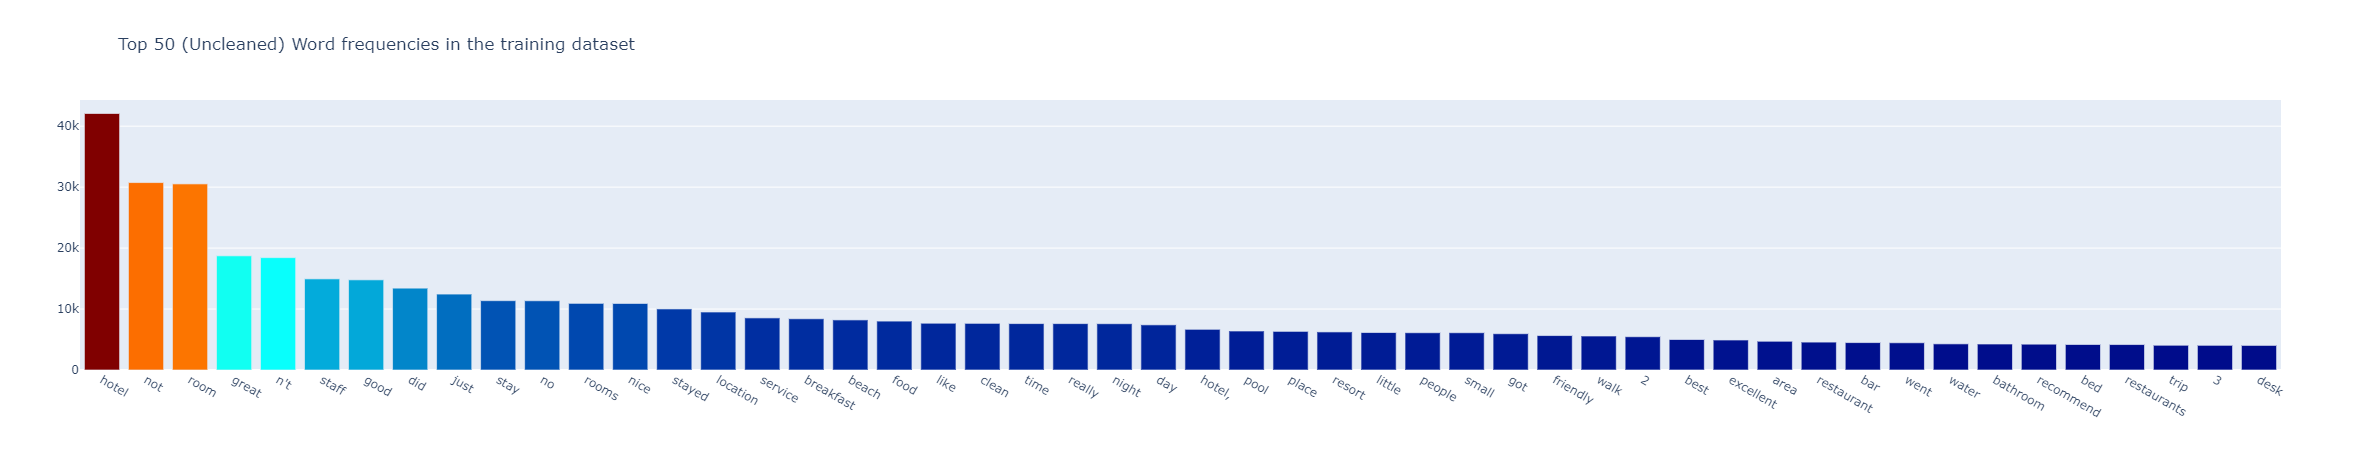

In [11]:
all_words = df['Review'].str.split(expand=True).unstack().value_counts()

data = [go.Bar(
            x = all_words.index.values[0:50],
            y = all_words.values[0:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[0:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


* Hotel, Room and Staff are the 3 one of the top 5 most repeated words in our reviews are which are obvioused as the reviews are related to hotels and in this reviews people talked about the Hotel services, location, ammenities, and its staff and room

In [12]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

## Most repeated word have shown using Word Cloud here

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



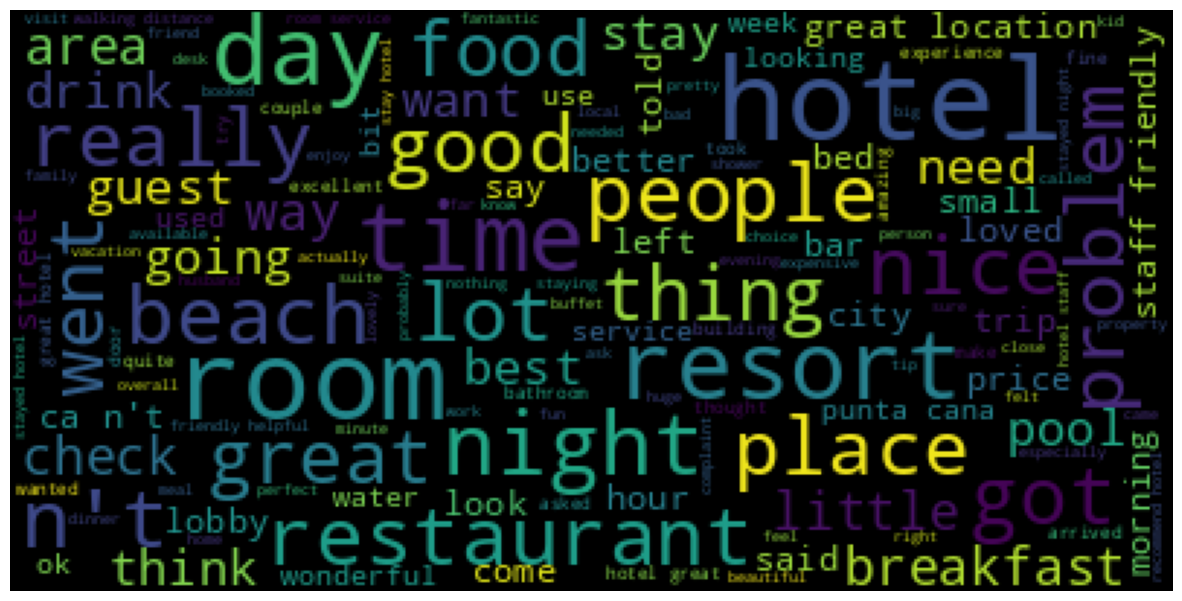

In [13]:
show_wordcloud(df["Review"].values)

/tmp/ipykernel_32/2792146095.py:3: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



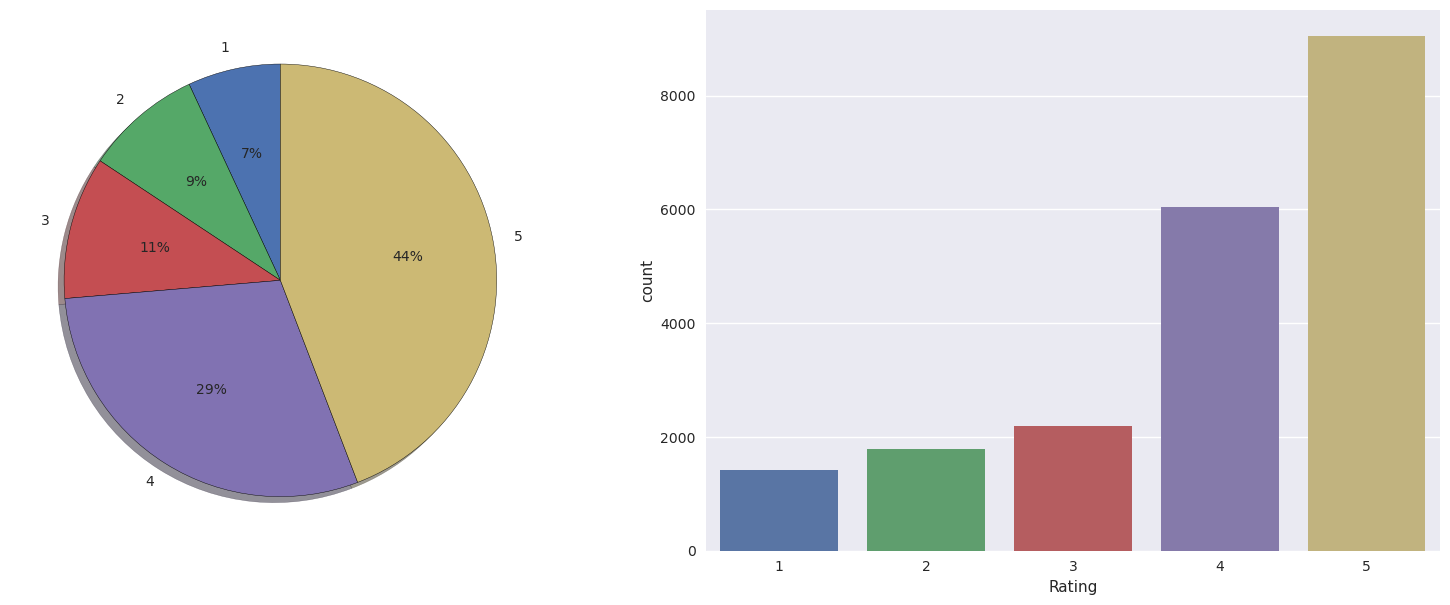

In [14]:
Rat_Count = df['Rating'].value_counts().sort_index(ascending=True).to_frame().T

plt.style.use('seaborn')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
plt.tight_layout()

ax[0].pie(Rat_Count.values.reshape(-1), startangle=90, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', shadow=True, labels = Rat_Count.columns)
sns.countplot(data = df, x = 'Rating', ax=ax[1]) #hue = 'loan_status',
fig.show()

* Around 75% of the review given by a customers are positive
* 10% reviews are neutral
* Almost15% reviews are negative
* 44% people given 5 star rating which is very goot for any hotel i.e. customers are completely satisfy with the services offered by customers

In [15]:
df['Review'].head()

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms not 4* experience hotel monaco seat...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object

### Converting emojis into text

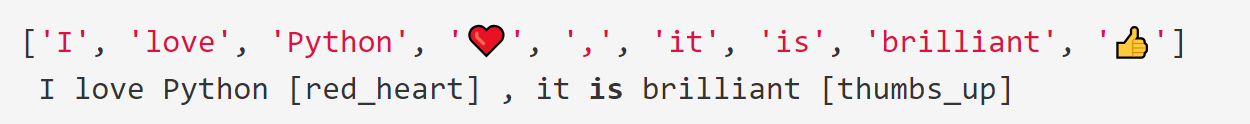

In [16]:
def handle_emoji(string):
    emojis = demoji.findall(string)

    for emoji in emojis:
        string = string.replace(emoji, " " + emojis[emoji].split(":")[0])

    return string

In [17]:
tqdm.pandas()

df['Review_new'] = df['Review'].progress_map(handle_emoji)
df.head()

100%|██████████| 20491/20491 [02:27<00:00, 139.24it/s]


,Review,Rating,Review_new
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4* experience hotel monaco seat...
3,"unique, great stay, wonderful time hotel monac...",5,"unique, great stay, wonderful time hotel monac..."
4,"great stay great stay, went seahawk game aweso...",5,"great stay great stay, went seahawk game aweso..."


### Standardizing a text by making all the character consistent by remocving all the special character and making all character into lower case

In [18]:
def word_tokenizer(text):

    # Lower Case
    text = text.lower()

    # removes punctuation,numbers and returns list of words
    text = re.sub('[^A-Za-z]+', ' ', text)
    
    # Remove distracting single quotes
    text = re.sub("\'", "", text)

    # Spilt the df
    text = text.split()

    return text

In [19]:
# label encode
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2
    
# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

In [20]:
# encode label and mapping label name
df["label"] = df["Rating"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))
df.head()

,Review,Rating,Review_new,label,label_name
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,2,Positive
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,0,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4* experience hotel monaco seat...,1,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,"unique, great stay, wonderful time hotel monac...",2,Positive
4,"great stay great stay, went seahawk game aweso...",5,"great stay great stay, went seahawk game aweso...",2,Positive


In [21]:
# Function to clean the review
def clean_review(review):
    # Remove special characters
    cleaned = re.sub(r'[^a-zA-Z\s]', '', review)
    
    # Split, filter words based on length, and join back
    cleaned = ' '.join([word for word in cleaned.split() if len(word) > 2])
    
    return cleaned

In [22]:
df['Review_new'] = df['Review_new'].apply(clean_review)
df.head()

,Review,Rating,Review_new,label,label_name
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,2,Positive
1,ok nothing special charge diamond member hilto...,2,nothing special charge diamond member hilton d...,0,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not experience hotel monaco seattle...,1,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,2,Positive
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,2,Positive


In [23]:
# valvulate char count for each review
df['char_count'] = df['Review'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    plt.suptitle(f'{title}', fontsize=24)

In [ ]:
plot_dist3(df, 'char_count', 'Characters Count in Data')

In [25]:
# Creating a new feature for the visualization.
df['Character Count'] = df['Review'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    plt.suptitle(f'{title}', fontsize=24)

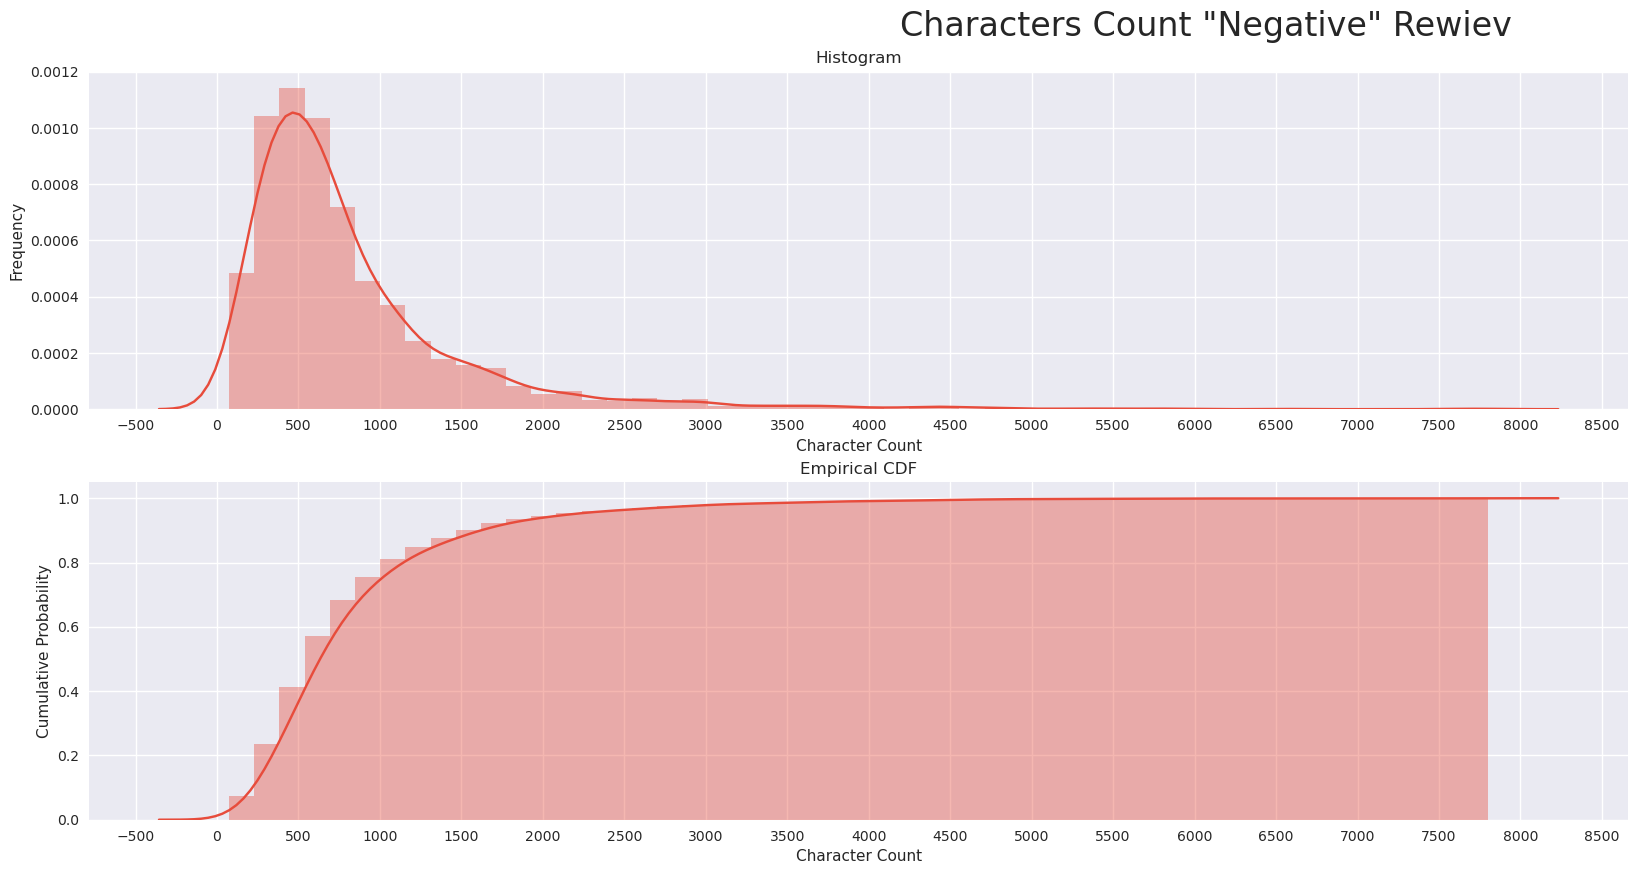

In [26]:
plot_dist3(df[df['label'] == 0], 'Character Count', 'Characters Count "Negative" Rewiev')

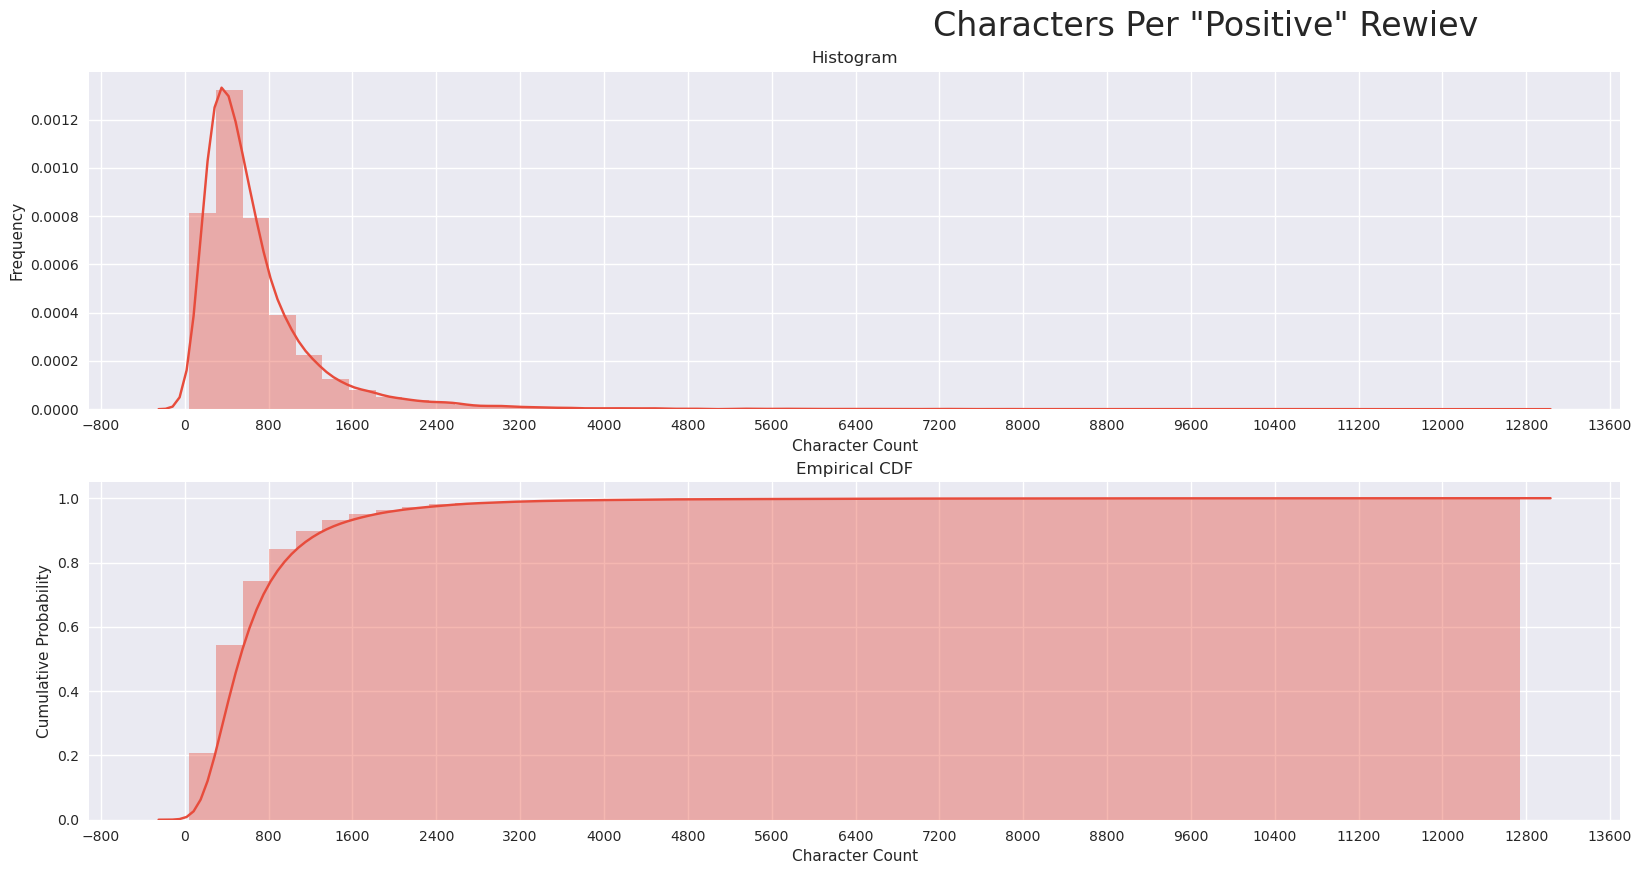

In [27]:
plot_dist3(df[df['label'] == 2], 'Character Count', 'Characters Per "Positive" Rewiev')

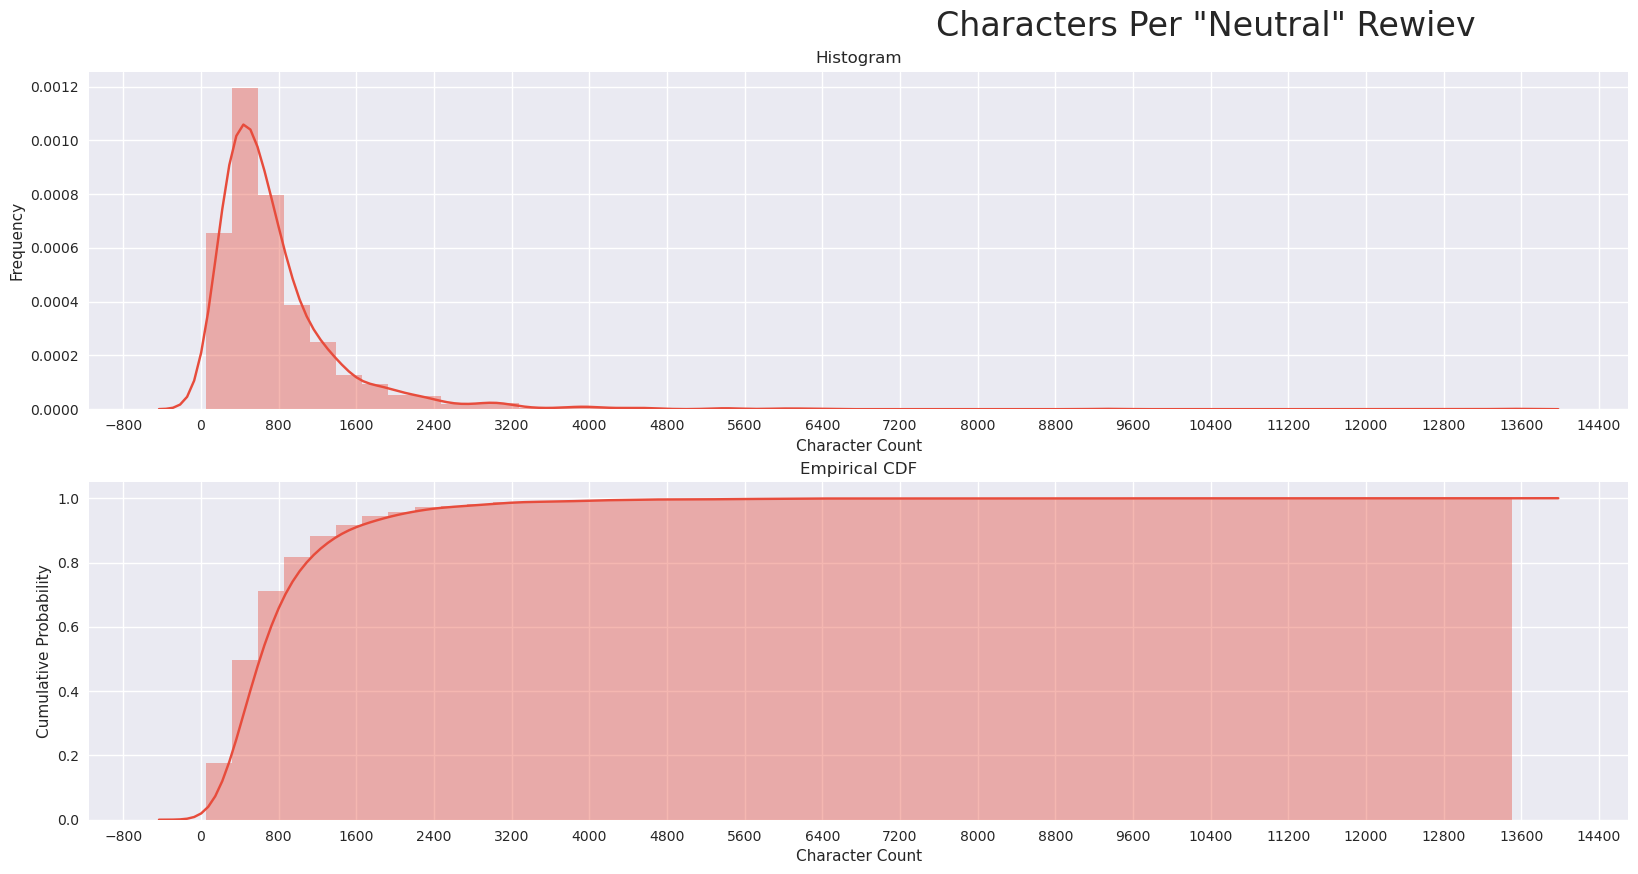

In [28]:
plot_dist3(df[df['label'] == 1], 'Character Count', 'Characters Per "Neutral" Rewiev')

#### **Positve review given by customers are longer then negativea and as almost as long as neutrals**

In [29]:
def sent_to_words(text) : 
    list_of_tokens = gensim.utils.simple_preprocess(text, deacc=True, min_len=3)
    return list_of_tokens

# **Tokenization**


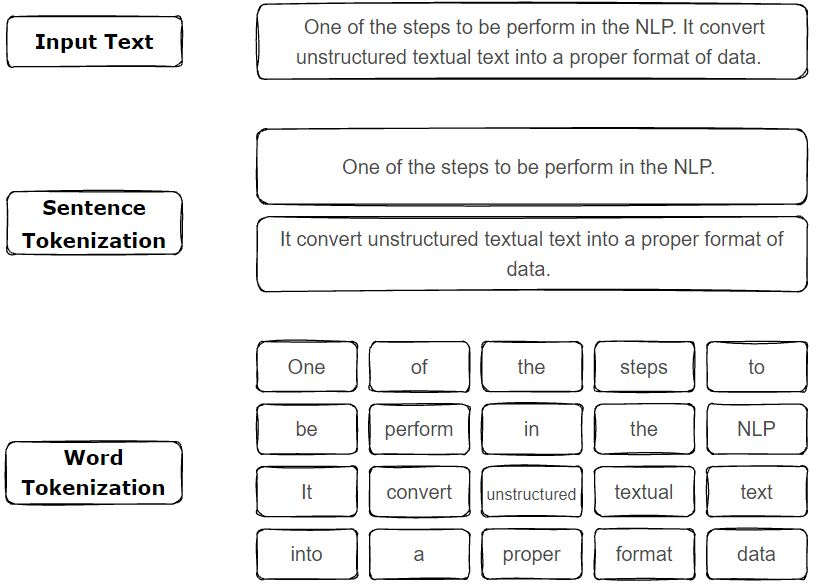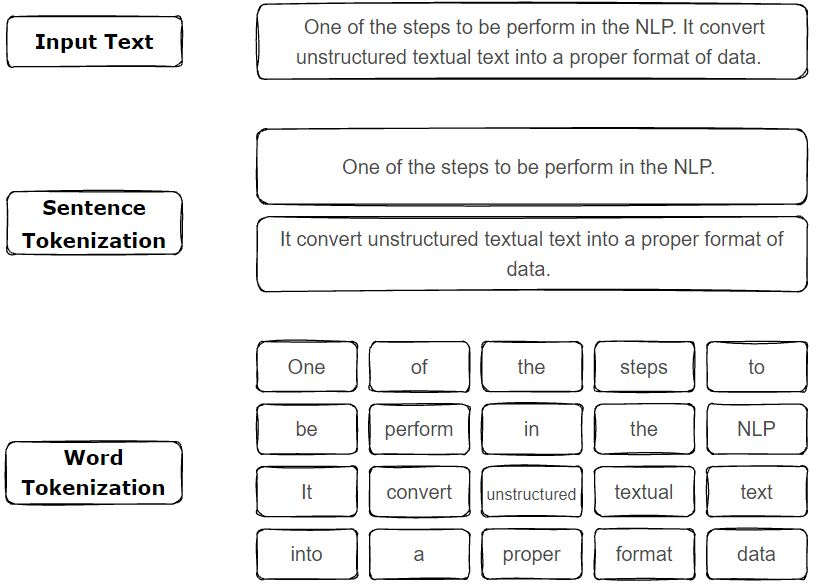

There are two ways in which we can convert the whole text into token: 
1. using **gensim.utils.simple_preprocess**
2. using **pandas split function**


well you can do multiple things using **gensim.utils.simple_preprocess** like converting the whole text into a single case and using min length funciton you can define the minimum size of the each token.

If you already prepocessed this thing then you can go with split funciton in pandas which takes significantly less time then previous one

In [30]:
df['Review_new_genism'] = df['Review_new'].progress_map(sent_to_words)
df.head()

100%|██████████| 20491/20491 [00:06<00:00, 3308.33it/s]


,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,nothing special charge diamond member hilton d...,0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not experience hotel monaco seattle...,1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ..."
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game..."


In [31]:
df['Review_new'] = df['Review_new'].progress_map(word_tokenizer)
df.head()

100%|██████████| 20491/20491 [00:01<00:00, 17864.36it/s]


,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[nothing, special, charge, diamond, member, hi...",0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, experience, hotel, monaco, ...",1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ..."
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, went, seahawk, game...",2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game..."


In [32]:
df.head(10)

,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[nothing, special, charge, diamond, member, hi...",0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, experience, hotel, monaco, ...",1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ..."
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, went, seahawk, game...",2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game..."
5,love monaco staff husband stayed hotel crazy w...,5,"[love, monaco, staff, husband, stayed, hotel, ...",2,Positive,1002,1002,"[love, monaco, staff, husband, stayed, hotel, ..."
6,"cozy stay rainy city, husband spent 7 nights m...",5,"[cozy, stay, rainy, city, husband, spent, nigh...",2,Positive,748,748,"[cozy, stay, rainy, city, husband, spent, nigh..."
7,"excellent staff, housekeeping quality hotel ch...",4,"[excellent, staff, housekeeping, quality, hote...",2,Positive,597,597,"[excellent, staff, housekeeping, quality, hote..."
8,"hotel stayed hotel monaco cruise, rooms genero...",5,"[hotel, stayed, hotel, monaco, cruise, rooms, ...",2,Positive,419,419,"[hotel, stayed, hotel, monaco, cruise, rooms, ..."
9,excellent stayed hotel monaco past w/e delight...,5,"[excellent, stayed, hotel, monaco, past, delig...",2,Positive,271,271,"[excellent, stayed, hotel, monaco, past, delig..."


# Remove Stopwords

In [33]:
# Download stopwords
nltk.download('stopwords')

stopWords_nltk = set(stopwords.words('english'))
print(f"Stop Words in English : \n{ stopWords_nltk}")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Stop Words in English : 
{"you're", 'of', 'into', 'd', 'yours', 'they', 'more', 'their', 'she', 'or', 'couldn', 'same', "you'll", 'our', 'is', 'at', 'between', "shan't", 'weren', "won't", 'when', 'were', 'shan', 'through', 'them', "couldn't", 'mightn', 'both', 'very', 'have', 'does', 'itself', 'that', 'can', 've', 'didn', 'wouldn', 't', 'most', 'been', 'an', 'off', 'm', 'as', 'mustn', 'i', 'below', 'had', 'above', 'other', 'isn', 'those', "wouldn't", 'theirs', 'if', "it's", 'myself', 'up', 'hasn', 'under', 'on', 'its', 'o', 'nor', 'hadn', 'no', 'was', 'then', "wasn't", 'about', 'against', 'than', 'own', 'once', 'himself', 'him', 'now', 'while', 'aren', 'each', "didn't", "you'd", "that'll", 'who', 'some', 'further', 'ours', 'the', "hasn't", 'here', 'needn', 'only', "should've", 'these', 'why', 'herself', 'won', 're', 'again', 'your', "aren't", 'any', 'whom', 'you',

In [34]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopWords_nltk]
    return text

In [35]:
df['Review_new_model'] = df['Review_new'].progress_map(remove_stopwords)
df.head()

100%|██████████| 20491/20491 [00:00<00:00, 59711.07it/s]


,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism,Review_new_model
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[nothing, special, charge, diamond, member, hi...",0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi...","[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, experience, hotel, monaco, ...",1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, rooms, experience, hotel, monaco, seatt..."
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, went, seahawk, game...",2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game..."


## **Lemmatization**

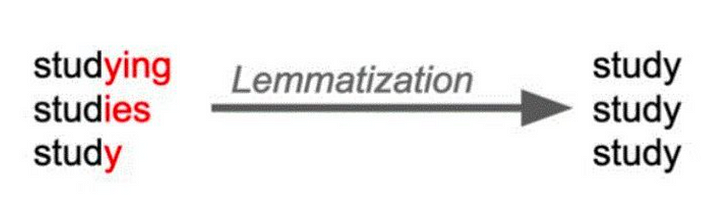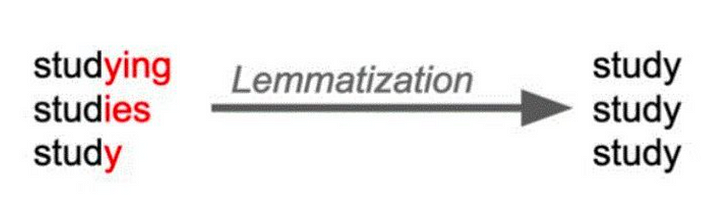

In [36]:
sp = spacy.load("en_core_web_sm")

def lemmatization(text):

    # text = [sp(word).lemma_ for word in text]

    text = " ".join(text)
    token = sp(text)

    text = [word.lemma_ for word in token]
    return text

In [37]:
df['Review_new_model'] = df['Review_new_model'].progress_map(lemmatization)
df.head()

100%|██████████| 20491/20491 [06:30<00:00, 52.44it/s]


,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism,Review_new_model
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, get, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[nothing, special, charge, diamond, member, hi...",0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi...","[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, experience, hotel, monaco, ...",1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, room, experience, hotel, monaco, seattl..."
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, went, seahawk, game...",2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, go, seahawk, game, ..."


In [38]:
df['Review_new'] = df['Review_new'].progress_map(lemmatization)
df.head()

100%|██████████| 20491/20491 [06:22<00:00, 53.57it/s]


,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism,Review_new_model
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, get, good, d...",2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, get, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[nothing, special, charge, diamond, member, hi...",0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi...","[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, room, not, experience, hotel, monaco, s...",1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, room, experience, hotel, monaco, seattl..."
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, go, seahawk, game, ...",2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, go, seahawk, game, ..."


In [39]:
texts = df['Review']
new = texts.str.split()
new = df['Review_new'].values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

**Top 10 most frequent occuring words**

In [40]:
most[0:10]

[('hotel', 52555),
 ('room', 46362),
 ('not', 34203),
 ('stay', 27835),
 ('good', 21654),
 ('great', 21233),
 ('do', 17853),
 ('staff', 16359),
 ('night', 14065),
 ('day', 12958)]

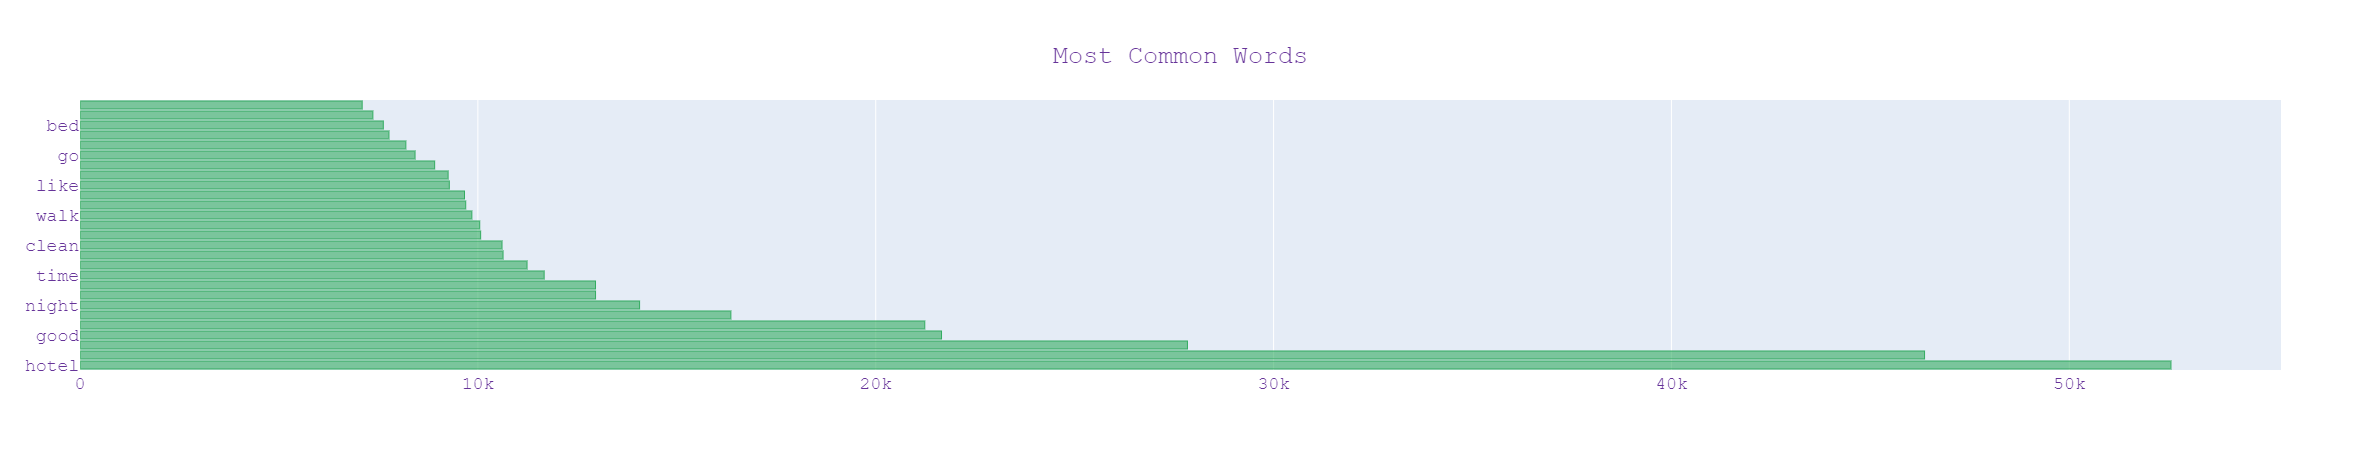

In [41]:
fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

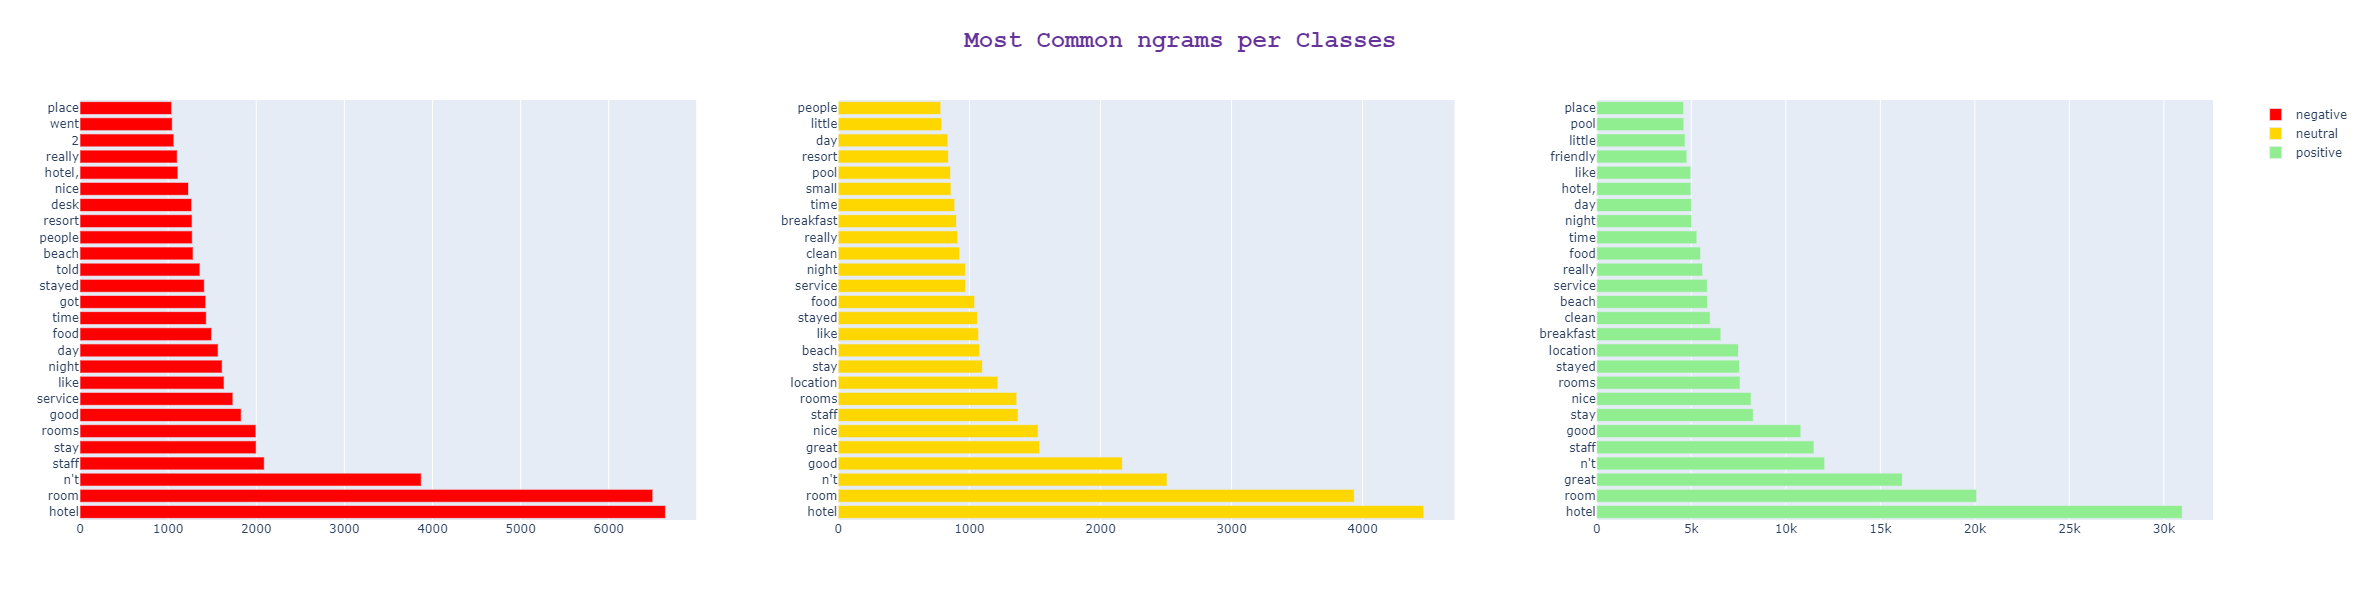

In [42]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]
colors = ['red', 'gold', 'lightgreen'] # 
for i in range(3):
    texts = df[df["label"] == i]['Review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [43]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [44]:
def generate_N_grams(text,ngram=1):
    words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]  
    print("Sentence after removing stopwords:",words)
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

In [45]:
df.head()

,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism,Review_new_model
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, get, good, d...",2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, get, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[nothing, special, charge, diamond, member, hi...",0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi...","[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, room, not, experience, hotel, monaco, s...",1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, room, experience, hotel, monaco, seattl..."
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, go, seahawk, game, ...",2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, go, seahawk, game, ..."


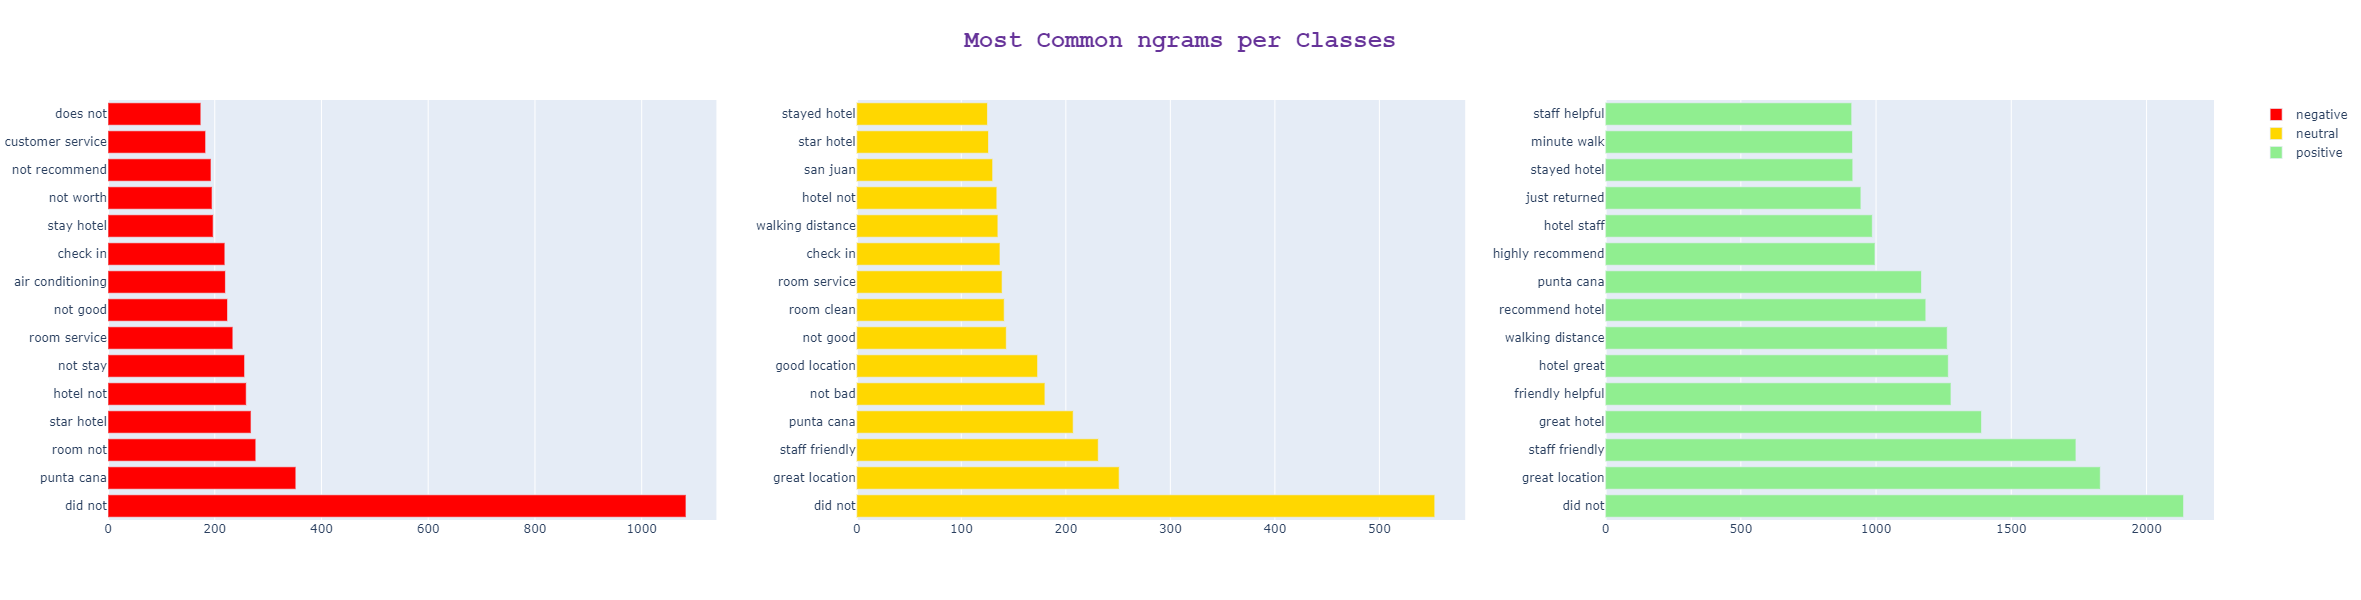

In [46]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]
colors = ['red', 'gold', 'lightgreen']  # 
for i in range(3):
    texts = df[df["label"] == i]['Review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))

#     for word, count in most[:30]:
#         if word not in stopWords_nltk:
#             x.append(word)
#             y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

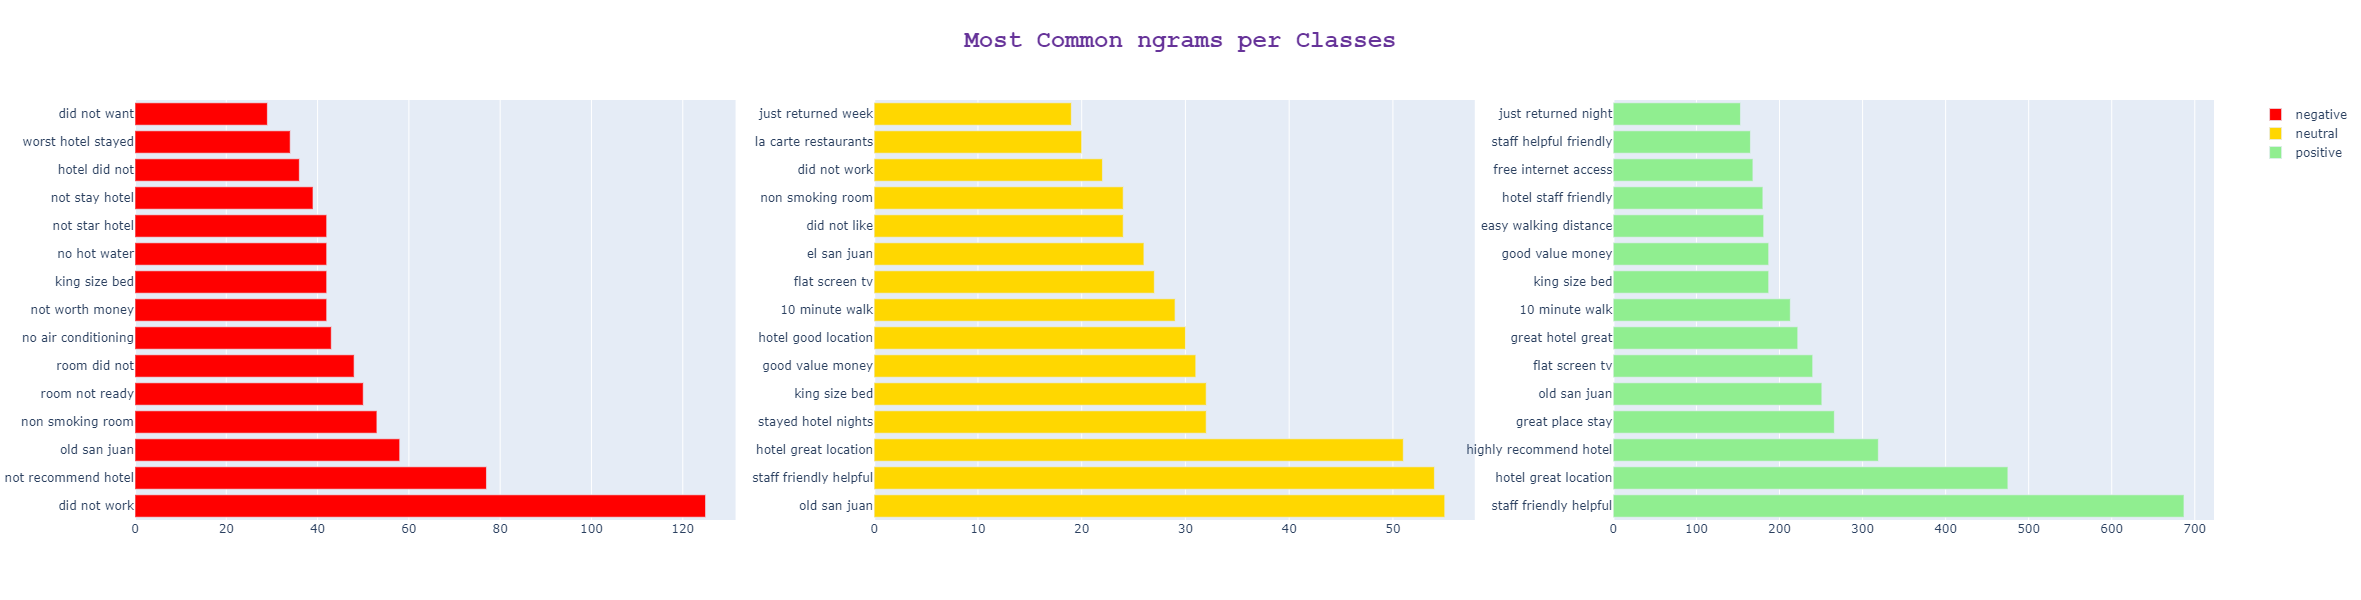

In [47]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]
colors = ['red', 'gold', 'lightgreen']  # 
for i in range(3):
    texts = df[df["label"] == i]['Review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [48]:
df.head()

,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism,Review_new_model
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, get, good, d...",2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, get, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[nothing, special, charge, diamond, member, hi...",0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi...","[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, room, not, experience, hotel, monaco, s...",1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, room, experience, hotel, monaco, seattl..."
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, go, seahawk, game, ...",2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, go, seahawk, game, ..."


In [49]:
# Function to filter elements with length greater than 3
def filter_list(lst):
    return [value for value in lst if len(value) > 2]

In [50]:
# Applying the function to the DataFrame column
df['Review_new'] = df['Review_new'].apply(filter_list)

In [51]:
df.head()

,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism,Review_new_model
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, get, good, d...",2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, get, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[nothing, special, charge, diamond, member, hi...",0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi...","[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, room, not, experience, hotel, monaco, s...",1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, room, experience, hotel, monaco, seattl..."
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, seahawk, game, awes...",2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, go, seahawk, game, ..."


In [52]:
# df['Review_Bigram'] =  [list(ngrams(tweet, 2)) for tweet in df['Review_new']]
# df['Review_Trigram'] =  [list(ngrams(tweet, 3)) for tweet in df['Review_new']]
# df.head()

In [53]:
# terms_bigram = [list(bigrams(tweet)) for tweet in df['Review_new']]

# **Postivie Review Graph**

In [206]:
terms_bigram = [list(ngrams(tweet, 3)) for tweet in df[df['label_name'] == 'Positive']['Review_new']]

print(terms_bigram[0][1:10])
print(' ')

word_counts = Counter(word for sublist in terms_bigram for word in sublist)

# Convert the Counter object to a list of tuples
bigram_counts = list(word_counts.items())

# Sort the list by frequency in descending order
bigram_counts.sort(key=lambda x: x[1], reverse=True)

# Print the list of tuples
# for word, frequency in word_frequency:
#     print(f"{word}: {frequency}")

print(bigram_counts[1:10])
print(' ')

bigram_df = pd.DataFrame(bigram_counts[1:10000], columns=['bigram', 'count'])
bigram_df.tail()

[('hotel', 'expensive', 'parking'), ('expensive', 'parking', 'get'), ('parking', 'get', 'good'), ('get', 'good', 'deal'), ('good', 'deal', 'stay'), ('deal', 'stay', 'hotel'), ('stay', 'hotel', 'anniversary'), ('hotel', 'anniversary', 'arrive'), ('anniversary', 'arrive', 'late')]
 
[(('hotel', 'great', 'location'), 467), (('highly', 'recommend', 'hotel'), 319), (('great', 'place', 'stay'), 265), (('old', 'san', 'juan'), 244), (('great', 'hotel', 'great'), 221), (('king', 'size', 'bed'), 218), (('just', 'return', 'night'), 200), (('stay', 'hotel', 'night'), 196), (('hotel', 'staff', 'friendly'), 180)]
 


,bigram,count
9994,"(stay, night, enjoy)",4
9995,"(concierge, staff, extremely)",4
9996,"(pool, nice, room)",4
9997,"(leave, room, not)",4
9998,"(not, really, complaint)",4


**Plot Graph**

Shape of df (4011, 2)
 
Graph Edges :  [('hotel', 'great location'), ('hotel', 'highly recommend'), ('hotel', 'great great'), ('hotel', 'stay night'), ('hotel', 'staff friendly'), ('hotel', 'stay hotel'), ('hotel', 'good stay'), ('hotel', 'good location'), ('hotel', 'definitely recommend'), ('hotel', 'great stay'), ('hotel', 'excellent location'), ('hotel', 'minute walk'), ('hotel', 'just return'), ('hotel', 'definitely stay'), ('hotel', 'centrally locate'), ('hotel', 'perfect location'), ('hotel', 'staff helpful'), ('hotel', 'recommend stay'), ('hotel', 'nice stay'), ('hotel', 'spend night'), ('hotel', 'room clean'), ('hotel', 'great value'), ('hotel', 'good value'), ('hotel', 'night stay'), ('hotel', 'location stay'), ('hotel', 'great hotel'), ('hotel', 'great little'), ('staff', 'helpful friendly'), ('staff', 'extremely helpful'), ('staff', 'extremely friendly'), ('staff', 'friendly helpful'), ('staff', 'clean friendly'), ('staff', 'speak english'), ('room', 'good size'), ('room', '

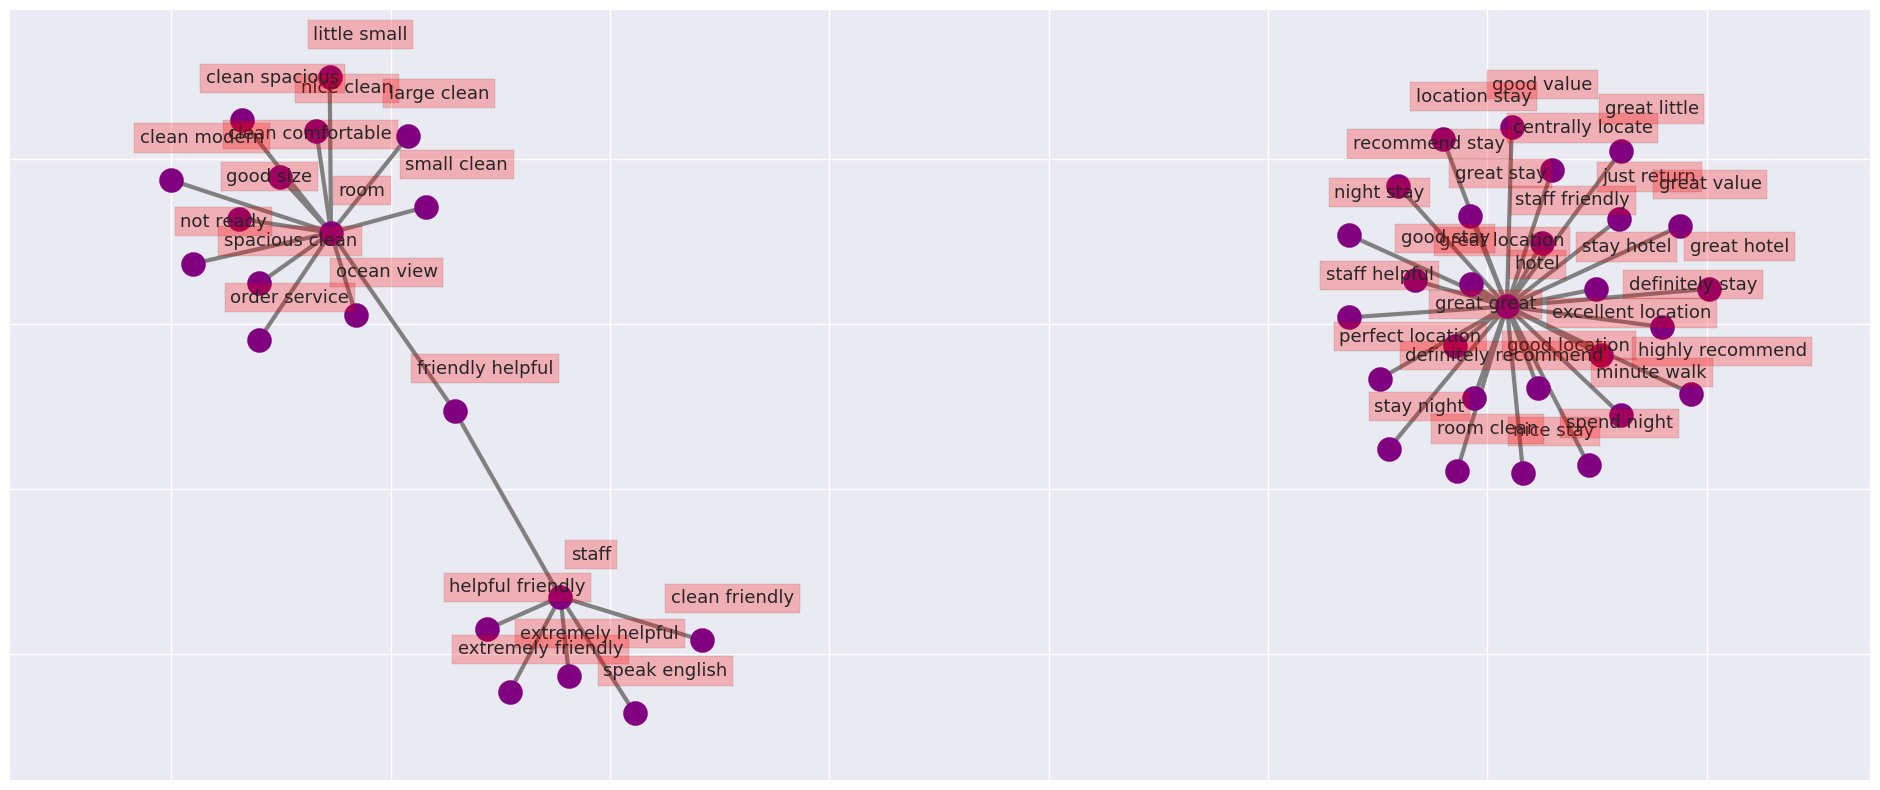

In [221]:
list_check = ['hotel', 'room', 'rooms', 'staff', 'food']
# list_check = ['parking']

bigram_df = bigram_df[bigram_df['bigram'].apply(lambda x: any(val in x for val in list_check)) == True]
bigram_df.head(10)

print('Shape of df', bigram_df.shape)
print(' ')

d = bigram_df.head(50).set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    if k[0] in list_check:
        l = k[1] + ' ' + k[2]
        m = k[0]
#         print('1', l, m)
        
    elif k[1] in list_check:
        l = k[0] + ' ' + k[2]
        m = k[1]
#         print('2', l, m)
        
    elif k[2] in list_check:
        l = k[0] + ' ' + k[1]
        m = k[2]
#         print('3', l, m)
    
    G.add_edge(m, l, weight=(v * 10))

# G.add_node("hotel", weight=100)

print('Graph Edges : ', G.edges)
print(' ')

fig, ax = plt.subplots(figsize=(24, 10))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
#     x, y = value[0]+.135, value[1]+.045
    x, y = value[0]+.035, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

This graph indicates that people are satisfied with the following services related to the hotel, room, and staff :

* Hotel
    1. Room
    2. Location
    3. Cleanliness
    4. Cost-effective
    
* Room
    1. Spacious
    2. Modern
    3. Cleanliness and Comfortable

* Staff
    1. Friendly
    2. Hellpful
    2. English Speaking

# **Negative Review Graph**

In [205]:
terms_bigram = [list(ngrams(tweet, 3)) for tweet in df[df['label_name'] == 'Negative']['Review_new']]

print(terms_bigram[0][1:10])
print(' ')

word_counts = Counter(word for sublist in terms_bigram for word in sublist)

# Convert the Counter object to a list of tuples
bigram_counts = list(word_counts.items())

# Sort the list by frequency in descending order
bigram_counts.sort(key=lambda x: x[1], reverse=True)

# Print the list of tuples
# for word, frequency in word_frequency:
#     print(f"{word}: {frequency}")

print(bigram_counts[1:10])
print(' ')

bigram_df = pd.DataFrame(bigram_counts[1:10000], columns=['bigram', 'count'])
bigram_df.tail()

[('special', 'charge', 'diamond'), ('charge', 'diamond', 'member'), ('diamond', 'member', 'hilton'), ('member', 'hilton', 'decide'), ('hilton', 'decide', 'chain'), ('decide', 'chain', 'shot'), ('chain', 'shot', 'anniversary'), ('shot', 'anniversary', 'seattle'), ('anniversary', 'seattle', 'start')]
 
[(('room', 'not', 'ready'), 63), (('old', 'san', 'juan'), 56), (('king', 'size', 'bed'), 51), (('room', 'not', 'clean'), 48), (('not', 'stay', 'hotel'), 47), (('not', 'star', 'hotel'), 46), (('bad', 'hotel', 'stay'), 41), (('not', 'worth', 'money'), 40), (('stay', 'hotel', 'night'), 30)]
 


,bigram,count
9994,"(riu, palace, say)",2
9995,"(riu, palace, impressed)",2
9996,"(rent, condo, house)",2
9997,"(condo, house, florida)",2
9998,"(not, want, deal)",2


**Plot Graph**

Shape of df (2910, 2)
 
Graph Edges :  [('hotel', 'great location'), ('hotel', 'stay night'), ('hotel', 'good location'), ('hotel', 'good thing'), ('hotel', 'staff friendly'), ('hotel', 'minute walk'), ('hotel', 'location great'), ('hotel', 'stay hotel'), ('hotel', 'not star'), ('hotel', 'room small'), ('hotel', 'conveniently locate'), ('hotel', 'room clean'), ('hotel', 'location stay'), ('hotel', 'nothing special'), ('hotel', 'not bad'), ('hotel', 'right outside'), ('hotel', 'thing location'), ('hotel', 'clean staff'), ('hotel', 'nice not'), ('hotel', 'not recommend'), ('great location', 'room'), ('staff', 'friendly helpful'), ('staff', 'clean friendly'), ('staff', 'helpful friendly'), ('staff', 'speak english'), ('staff', 'friendly room'), ('staff', 'not friendly'), ('room', 'small clean'), ('room', 'spacious clean'), ('room', 'not ready'), ('room', 'good size'), ('room', 'double bed'), ('room', 'ocean view'), ('room', 'order service'), ('room', 'clean comfortable'), ('room', 'clean 

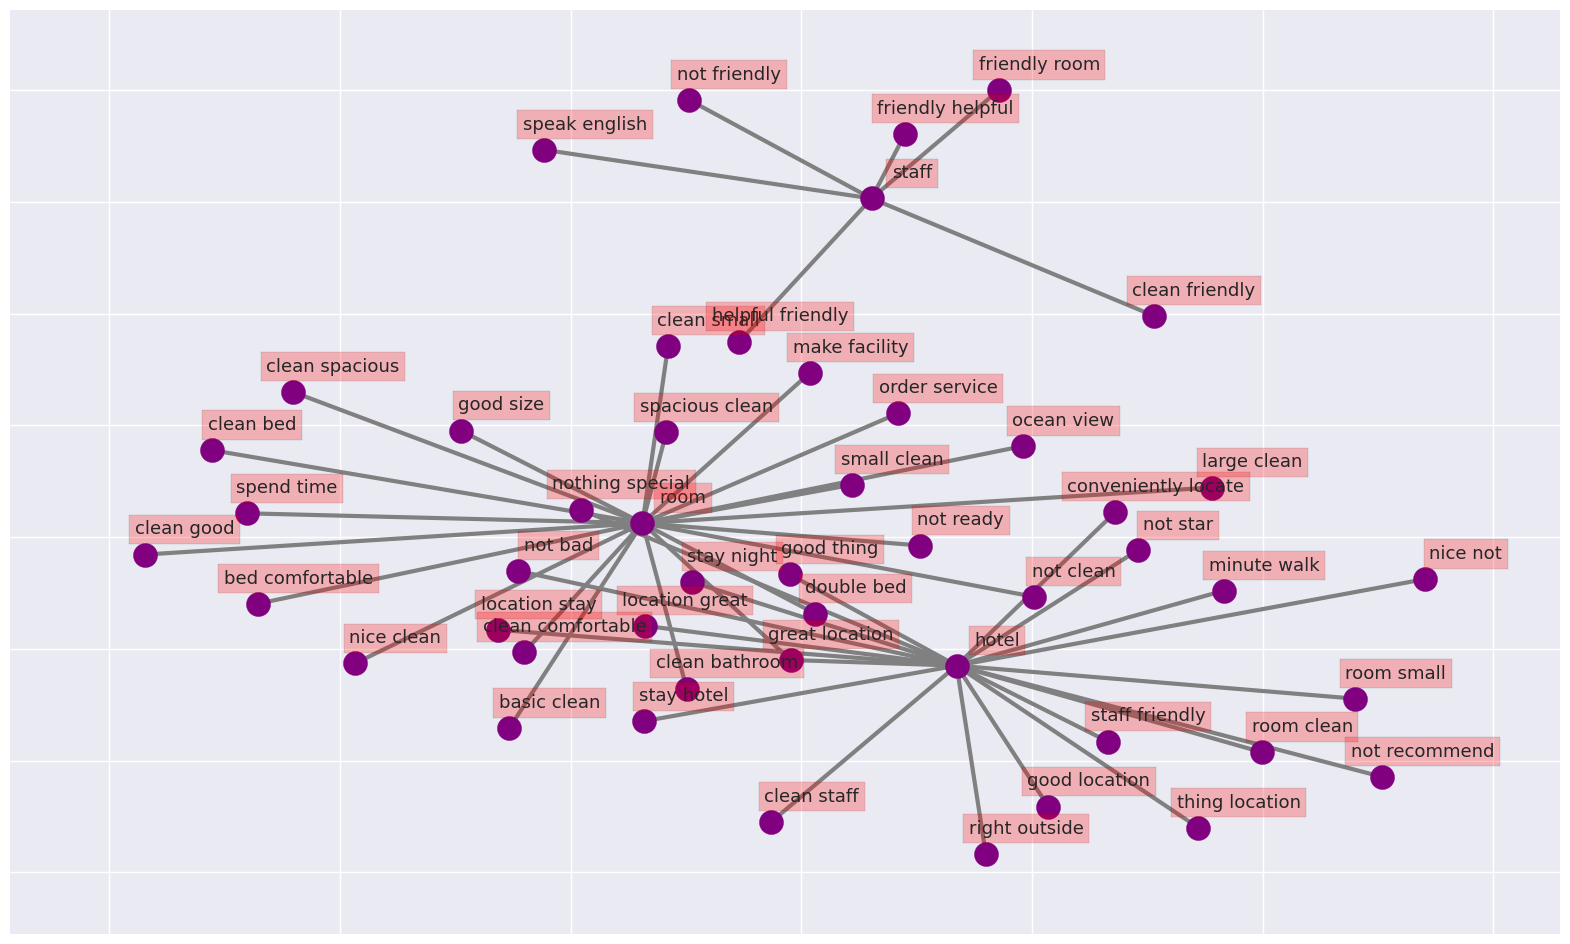

In [204]:
list_check = ['hotel', 'room', 'rooms', 'staff', 'food']
# list_check = ['parking']

bigram_df = bigram_df[bigram_df['bigram'].apply(lambda x: any(val in x for val in list_check)) == True]
bigram_df.head(10)

print('Shape of df', bigram_df.shape)
print(' ')

d = bigram_df.head(50).set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    if k[0] in list_check:
        l = k[1] + ' ' + k[2]
        m = k[0]
#         print('1', l, m)
        
    elif k[1] in list_check:
        l = k[0] + ' ' + k[2]
        m = k[1]
#         print('2', l, m)
        
    elif k[2] in list_check:
        l = k[0] + ' ' + k[1]
        m = k[2]
#         print('3', l, m)
    
    G.add_edge(m, l, weight=(v * 10))

# G.add_node("hotel", weight=100)

print('Graph Edges : ', G.edges)
print(' ')

fig, ax = plt.subplots(figsize=(20, 12))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
#     x, y = value[0]+.135, value[1]+.045
    x, y = value[0]+.035, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

This graph indicates that people are disappointed with the following services related to the hotel, room, and staff :

* Hotel
    1. Cleanliness
    2. Location
    3. Star
    
* Room
    1. Basic Clean
    2. Ordinary

* Staff
    1. Behaviour

# **Neutral Negative Review**

In [222]:
terms_bigram = [list(ngrams(tweet, 3)) for tweet in df[df['label_name'] == 'Neutral']['Review_new']]

print(terms_bigram[0][1:10])
print(' ')

word_counts = Counter(word for sublist in terms_bigram for word in sublist)

# Convert the Counter object to a list of tuples
bigram_counts = list(word_counts.items())

# Sort the list by frequency in descending order
bigram_counts.sort(key=lambda x: x[1], reverse=True)

# Print the list of tuples
# for word, frequency in word_frequency:
#     print(f"{word}: {frequency}")

print(bigram_counts[1:10])
print(' ')

bigram_df = pd.DataFrame(bigram_counts[1:10000], columns=['bigram', 'count'])
bigram_df.tail()

[('room', 'not', 'experience'), ('not', 'experience', 'hotel'), ('experience', 'hotel', 'monaco'), ('hotel', 'monaco', 'seattle'), ('monaco', 'seattle', 'good'), ('seattle', 'good', 'hotel'), ('good', 'hotel', 'levelpositive'), ('hotel', 'levelpositive', 'large'), ('levelpositive', 'large', 'bathroom')]
 
[(('hotel', 'great', 'location'), 52), (('staff', 'friendly', 'helpful'), 51), (('stay', 'hotel', 'night'), 42), (('king', 'size', 'bed'), 39), (('good', 'value', 'money'), 33), (('hotel', 'good', 'location'), 30), (('just', 'return', 'week'), 21), (('room', 'small', 'clean'), 21), (('good', 'thing', 'hotel'), 21)]
 


,bigram,count
9994,"(bedslinen, soft, comfortable)",1
9995,"(soft, comfortable, bring)",1
9996,"(comfortable, bring, extra)",1
9997,"(bring, extra, pillow)",1
9998,"(extra, pillow, request)",1


**Plot Graph**

Shape of df (2910, 2)
 
Graph Edges :  [('hotel', 'great location'), ('hotel', 'stay night'), ('hotel', 'good location'), ('hotel', 'good thing'), ('hotel', 'staff friendly'), ('hotel', 'minute walk'), ('hotel', 'location great'), ('hotel', 'stay hotel'), ('hotel', 'not star'), ('hotel', 'room small'), ('hotel', 'conveniently locate'), ('hotel', 'room clean'), ('hotel', 'location stay'), ('hotel', 'nothing special'), ('hotel', 'not bad'), ('hotel', 'right outside'), ('hotel', 'thing location'), ('hotel', 'clean staff'), ('hotel', 'nice not'), ('hotel', 'not recommend'), ('great location', 'room'), ('staff', 'friendly helpful'), ('staff', 'clean friendly'), ('staff', 'helpful friendly'), ('staff', 'speak english'), ('staff', 'friendly room'), ('staff', 'not friendly'), ('room', 'small clean'), ('room', 'spacious clean'), ('room', 'not ready'), ('room', 'good size'), ('room', 'double bed'), ('room', 'ocean view'), ('room', 'order service'), ('room', 'clean comfortable'), ('room', 'clean 

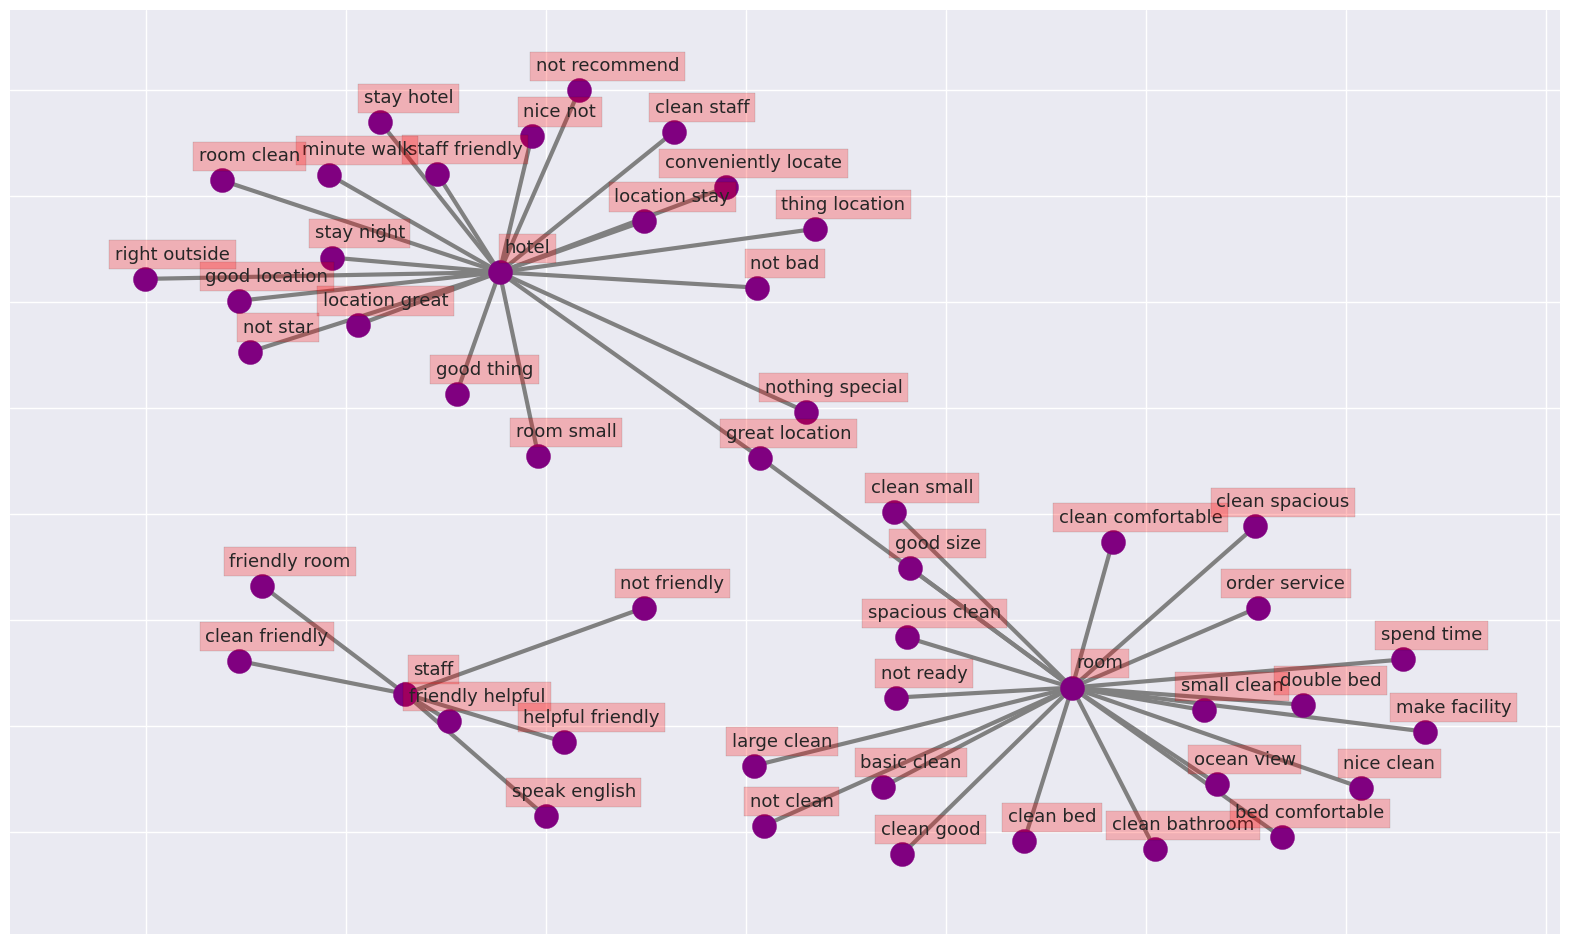

In [223]:
list_check = ['hotel', 'room', 'rooms', 'staff', 'food']
# list_check = ['parking']

bigram_df = bigram_df[bigram_df['bigram'].apply(lambda x: any(val in x for val in list_check)) == True]
bigram_df.head(10)

print('Shape of df', bigram_df.shape)
print(' ')

d = bigram_df.head(50).set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    if k[0] in list_check:
        l = k[1] + ' ' + k[2]
        m = k[0]
#         print('1', l, m)
        
    elif k[1] in list_check:
        l = k[0] + ' ' + k[2]
        m = k[1]
#         print('2', l, m)
        
    elif k[2] in list_check:
        l = k[0] + ' ' + k[1]
        m = k[2]
#         print('3', l, m)
    
    G.add_edge(m, l, weight=(v * 10))

# G.add_node("hotel", weight=100)

print('Graph Edges : ', G.edges)
print(' ')

fig, ax = plt.subplots(figsize=(20, 12))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
#     x, y = value[0]+.135, value[1]+.045
    x, y = value[0]+.035, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

# **LDA Implementation**

In [73]:
df.head()

,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism,Review_new_model
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, get, good, d...",2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, get, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[nothing, special, charge, diamond, member, hi...",0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi...","[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, room, not, experience, hotel, monaco, s...",1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, room, experience, hotel, monaco, seattl..."
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, seahawk, game, awes...",2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, go, seahawk, game, ..."


In [57]:
docs = np.array(df['Review'])

In [58]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
# nltk.download()
from nltk.corpus import wordnet

In [59]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
#     lemmatizer = WordNetLemmatizer()
#     docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

docs = np.array(df['Review'])
docs = docs_preprocessor(docs)

In [61]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(df['Review_new'])
# Create Corpus
texts = df['Review_new']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 2), (29, 1)]


In [62]:
import pyLDAvis.gensim
from pprint import pprint
import gensim

# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"hotel" + 0.021*"room" + 0.016*"not" + 0.012*"stay" + 0.011*"good" + '
  '0.009*"great" + 0.008*"staff" + 0.006*"service" + 0.006*"night" + '
  '0.006*"just"'),
 (1,
  '0.020*"room" + 0.015*"stay" + 0.014*"not" + 0.012*"hotel" + 0.010*"good" + '
  '0.010*"great" + 0.009*"staff" + 0.008*"night" + 0.008*"resort" + '
  '0.008*"beach"'),
 (2,
  '0.033*"hotel" + 0.026*"room" + 0.021*"not" + 0.013*"stay" + 0.012*"great" + '
  '0.011*"good" + 0.007*"staff" + 0.007*"nice" + 0.007*"location" + '
  '0.006*"night"')]


In [144]:
from IPython.display import clear_output
# Computing coherence score for different size of topic

def calculate_topic_cv(texts,dictionary,topic_range):
    cv_score =[]
    topic_num = []
    for i in range(2, topic_range, 2):
        print(i)
        topic_num.append(i)
        Lda = gensim.models.LdaMulticore
#         Lda = gensim.models.ldamodel.LdaModel
        ldamodel = Lda(corpus, num_topics=i, id2word=dictionary, passes=10,random_state=45)
        cv_score.append(CoherenceModel(model=ldamodel,texts=texts,\
                                       dictionary=dictionary , coherence='c_v').get_coherence())
        clear_output()
    return topic_num,cv_score

In [127]:
topic_num,cv_score = calculate_topic_cv(df['Review_new_model'], id2word, 40)

In [181]:
Coherence_Score = pd.DataFrame(zip(topic_num,cv_score),columns=['Topic','Coherence_Score']).set_index('Topic').sort_values('Topic',ascending=True)
Coherence_Score

,Coherence_Score
Topic,
2,0.343143
4,0.344472
6,0.390050
8,0.390233
10,0.405309
12,0.442197
14,0.410072
16,0.447707
18,0.430857


In [177]:
# Convert reviews into bigrams
def review_to_bigram(review):
    tokens = word_tokenize(review)
    return [" ".join(bg) for bg in bigrams(tokens)]

# df['bigrams'] = df['Review'].apply(review_to_bigram)

# df['Test'] = df['bigrams'] + df['Review_new']
# df.head()

In [183]:
# Coherence_Score = pd.concat([Coherence_Score0, Coherence_Score1])
Coherence_Score = Coherence_Score.reset_index()
Coherence_Score = Coherence_Score.sort_values('Topic', ascending=True)
Coherence_Score.head()

,Topic,Coherence_Score
0,2,0.343143
1,4,0.344472
2,6,0.390050
3,8,0.390233
4,10,0.405309


In [ ]:
# Coherence_Score.info()

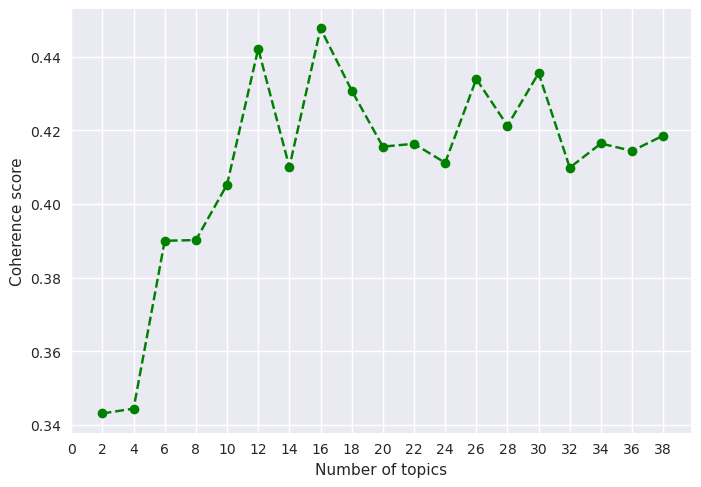

In [185]:
import matplotlib.pyplot as plt

plt.plot(Coherence_Score['Topic'], Coherence_Score['Coherence_Score'], color='green', marker='o', linestyle='dashed')
plt.xticks(range(0, 40, 2))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

In [ ]:
# a = df['Review_new_model'][0]
# a = id2word.doc2bow(a)

# lda_model[a]

In [186]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os
import pandas

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

if 1 == 1:
  LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
  with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

  # load the pre-prepared pyLDAvis data from disk
  with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, '/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.017170 -0.001906       1        1  50.609499
2      0.013874 -0.003687       2        1  32.024515
1      0.003296  0.005593       3        1  17.365986, topic_info=          Term          Freq         Total Category  logprob  loglift
56        room  44647.000000  44647.000000  Default  30.0000  30.0000
5249    resort   8102.000000   8102.000000  Default  29.0000  29.0000
23       great  20135.000000  20135.000000  Default  28.0000  28.0000
45         not  34072.000000  34072.000000  Default  27.0000  27.0000
5311     beach   9526.000000   9526.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
33    location   1547.910226  11247.329384   Topic3  -5.4159  -0.2326
41        nice   1598.984979  13505.365643   Topic3  -5.3834  -0.3831
31        like   1283.607419   9302.513069   Topic3  -5.6031  -0.2300
68        walk   1302.211380   9879.286811   Topic3  -5.5887  -0.2757
9        clean   1242.174507  10895.118827   Topic3  -5.6359  -0.4208

[299 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
348        1  0.298865    activity
348        2  0.571124    activity
348        3  0.130365    activity
29374      1  0.882904    aeroport
41562      1  0.167356        alam
...      ...       ...         ...
29033      1  0.180506  wellington
29033      2  0.782192  wellington
29033      3  0.060169  wellington
24556      1  0.226800        woth
24556      2  0.680401        woth

[569 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

# Topic Prediction

In [188]:
topic_lookup_data = pd.DataFrame((lda_model.print_topics()),columns=['Topic_Number','Top_Keywords'])
topic_lookup_data['Topic_Name'] = ['Hotel Stay', 'Mixed Issues','Hotel Staff Issues']
topic_lookup_data = topic_lookup_data[['Topic_Number','Topic_Name','Top_Keywords']]
topic_lookup_data['Top_Keywords'] = topic_lookup_data.Top_Keywords.str\
.replace(r'[^a-z]',' ',regex=True).apply(lambda x: x.split())
topic_lookup_data.style.set_properties(subset=['Top_Keywords'], **{'width': '300px'})

,Topic_Number,Topic_Name,Top_Keywords
0,0,Hotel Stay,"['hotel', 'room', 'not', 'stay', 'good', 'great', 'staff', 'night', 'nice', 'location']"
1,1,Mixed Issues,"['room', 'hotel', 'not', 'great', 'good', 'stay', 'day', 'staff', 'restaurant', 'night']"
2,2,Hotel Staff Issues,"['not', 'hotel', 'room', 'stay', 'good', 'great', 'resort', 'beach', 'day', 'staff']"


In [189]:
for index,sent in enumerate(lda_model[corpus]):
    topic_num =[]
    topic_details = sorted(sent,key=lambda x: x[1], reverse=True)[:2] # Getting top 2 topics in descending order
    topic_num.append(topic_details[0][0]) # Appending top topic
    if len(topic_details) > 1:
        if topic_details[1][1] > 0.35: # Appending second topic only if it has more than 35% influence on current row
            topic_num.append(topic_details[1][0])
    df.loc[index,'Topic_Number'] = ','.join(str(x) for x in sorted(topic_num))

In [190]:
df.head()

,Review,Rating,Review_new,label,label_name,char_count,Character Count,Review_new_genism,Review_new_model,Topic_Number
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, get, good, d...",2,Positive,593,593,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, get, good, d...",0
1,ok nothing special charge diamond member hilto...,2,"[nothing, special, charge, diamond, member, hi...",0,Negative,1689,1689,"[nothing, special, charge, diamond, member, hi...","[nothing, special, charge, diamond, member, hi...",0
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, room, not, experience, hotel, monaco, s...",1,Neutral,1427,1427,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, room, experience, hotel, monaco, seattl...","0,1"
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",2,Positive,600,600,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...",0
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, seahawk, game, awes...",2,Positive,1281,1281,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, go, seahawk, game, ...",1


In [191]:
for index,topic_num in enumerate(df.Topic_Number):
    topic_name_list=[]
    for single_topic_num in topic_num.split(','):
        single_topic_num=int(single_topic_num)
        topic_name_list.append(topic_lookup_data.loc\
                               [topic_lookup_data.Topic_Number == single_topic_num,'Topic_Name'][single_topic_num]) 
        # Extracting topic names from lookup table
        
    df.loc[index,'Topic_Name'] =' & '.join(topic_name_list)

## **Visualization**

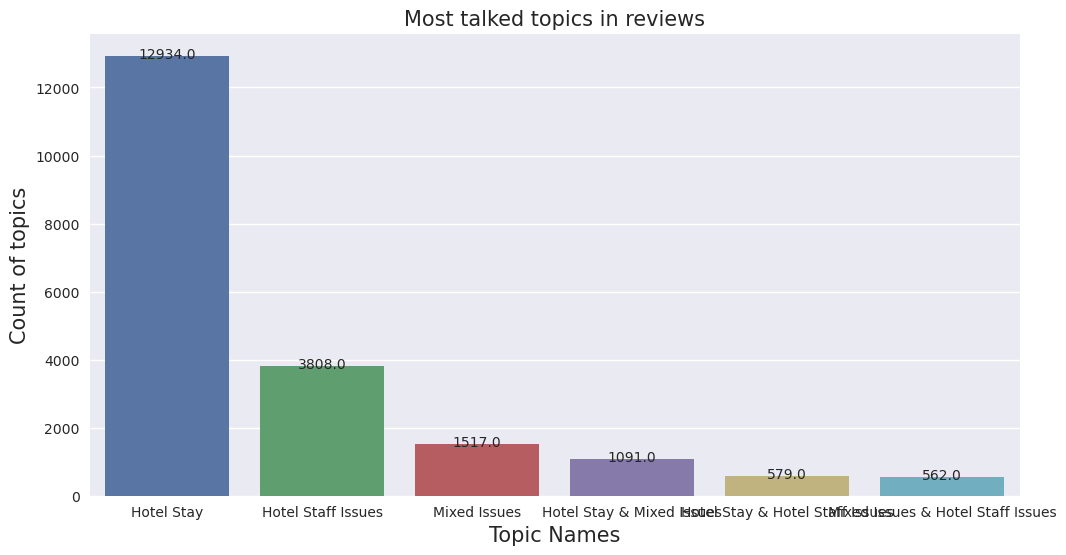

In [193]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x=df.Topic_Name.value_counts()[:6].index,y=df.Topic_Name.value_counts()[:6].values)
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+50),ha = 'center', va = 'center')
plt.xlabel('Topic Names',size=15)
plt.ylabel('Count of topics',size=15)
plt.title('Most talked topics in reviews',size=15)
plt.show()

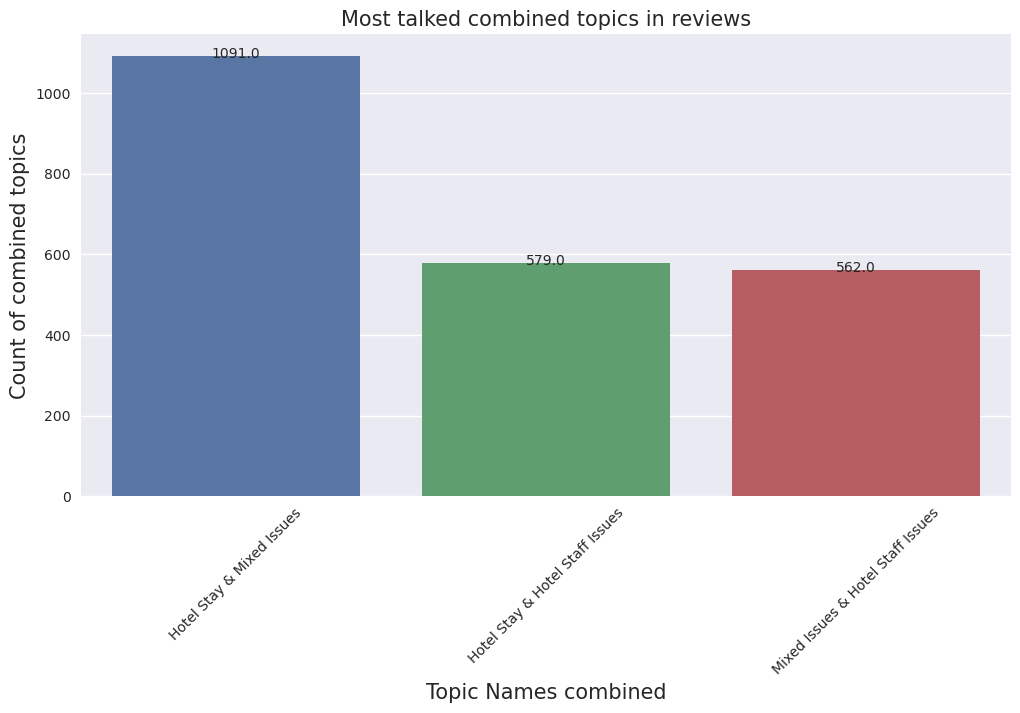

In [194]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x=df.Topic_Name.value_counts()[3:].index,y=df.Topic_Name.value_counts()[3:].values)
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+5),ha = 'center', va = 'center')
plt.xlabel('Topic Names combined',size=15)
plt.ylabel('Count of combined topics',size=15)
plt.title('Most talked combined topics in reviews',size=15)
plt.xticks(rotation=45)
plt.show()